In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os 
import sys
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
import statistics as stats
from uncertainties import ufloat
import math

In [2]:
hdu = fits.open('/Users/quinncasey/Desktop/research/eboss/spLine_trim_dr16_eboss.fits')

In [3]:
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'o3', 'o3_err', 'n2', 'n2_err', 'z']
data_dict = {'ha':ha, 'ha_err':ha_err, 'hb':hb, 'hb_err':hb_err, 'o3':o3, 
            'o3_err':o3_err, 'n2':n2, 'n2_err':n2_err, 'z':z}
df = pd.DataFrame(data_dict)

In [5]:
for name in data_names: 
    df = df.loc[df[name].notnull()]

In [6]:
df = df.loc[(df['ha']/df['ha_err']) > 3]
df = df.loc[(df['hb']/df['hb_err']) > 3]
df = df.loc[(df['n2']/df['n2_err']) > 3]
df = df.loc[(df['o3']/df['o3_err']) > 3]

df = df.query('z > 0.5 & z <=0.55')

In [7]:
def low_met_agn(df): 
    x_values = df.x.values
    y_values = df.y.values.tolist()
    
    z_1 = df['z'].values
    ha_1 = df['ha'].values
    ha_err_1 = df['ha_err'].values
    hb_1 = df['hb'].values
    hb_err_1 = df['hb_err'].values
    o3_1 = df['o3'].values
    o3_err_1 = df['o3_err'].values
    n2_1 = df['n2'].values
    n2_err_1 = df['n2_err'].values
    
    
    kewl_agn_class_line_mod = (0.61/(x_values-0.02-0.1833*(df.loc[:,"z"].median())))+1.4+0.03*(df.loc[:,"z"].median())
    
    df = []
    
    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line_mod):
        if x < -0.8 and y > agn_line:
            df.append('lowmetagn')
        elif x >=-0.8 and y > agn_line:
            df.append('agn')
        elif x > 0.0:
            df.append('agn')
        else: 
            df.append('starform')
            
    return df, ha_1, ha_err_1, hb_1, hb_err_1, n2_1, n2_err_1, o3_1, o3_err_1, z_1

In [8]:
df['x'] = np.log10(df['n2']/df['ha'])
df['y'] = np.log10(df['o3']/df['hb'])

df1 = low_met_agn(df)

In [9]:
df1 = pd.DataFrame(df1)
df1 = df1.transpose()
df1.columns = ['Type', 'ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z']

In [10]:
dfagn = df1[df1.Type != 'starform']
dfsf = df1[df1.Type != 'agn']
dflowmetagn = df1[df1.Type != 'agn']

dfagn = dfagn[dfagn.Type != 'lowmetagn']
dfsf = dfsf[dfsf.Type != 'lowmetagn']
dflowmetagn = dflowmetagn[dflowmetagn.Type != 'starform']

In [11]:
print(len(dfagn))
print(len(dfsf))
print(len(dflowmetagn))

4440
1693
1


In [12]:
dfsf = dfsf.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dfagn = dfagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])
dflowmetagn = dflowmetagn.drop(columns=['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err'])

In [13]:
d_MPC = cosmo.luminosity_distance(dflowmetagn['z'])
dflowmetagn['d (MPC)'] = d_MPC

In [14]:
d_MPC = cosmo.luminosity_distance(dfsf['z'])
dfsf['d (MPC)'] = d_MPC

In [15]:
d_MPC = cosmo.luminosity_distance(dfagn['z'])
dfagn['d (MPC)'] = d_MPC

In [16]:
dflowmetagn['d (cm)'] = dflowmetagn['d (MPC)']*3.08567758128E+24
dfsf['d (cm)'] = dfsf['d (MPC)']*3.08567758128E+24
dfagn['d (cm)'] = dfagn['d (MPC)']*3.08567758128E+24

In [17]:
def lumin(oxy3, d_cm):
    L = (oxy3)*(4)*(np.pi)*(d_cm**2)
    return L

In [18]:
dflowmetagn['luminosity_non_bolo'] = lumin(dflowmetagn['o3'], dflowmetagn['d (cm)'])
dfsf['luminosity_non_bolo'] = lumin(dfsf['o3'], dfsf['d (cm)'])
dfagn['luminosity_non_bolo'] = lumin(dfagn['o3'], dfagn['d (cm)'])

In [19]:
dflowmetagn['luminosity_non_bolo'] = dflowmetagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfsf['luminosity_non_bolo'] = dfsf.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

dfagn['luminosity_non_bolo'] = dfagn.luminosity_non_bolo.astype(float)
#dflowmetagn['luminosity_log10'] = np.log10(dflowmetagn['luminosity_non_bolo'])

In [20]:
def bolo_lumin(L_o3):
    L_iso_exp = ((0.5617)*(np.log10(L_o3)))+(22.186)
    #L_iso = np.log10(L_iso_exp)
    return L_iso_exp

In [21]:
bolo_non_log_lowmetagn = bolo_lumin(dflowmetagn['luminosity_non_bolo'])
dflowmetagn['log(bolo_lumin)'] = bolo_non_log_lowmetagn
bolo_lumin_lowmetagn = np.log10(bolo_non_log_lowmetagn)
dflowmetagn['Bolo_Lumin'] = bolo_lumin_lowmetagn

dflowmetagn['log(o3_lumin)'] = np.log10(dflowmetagn['luminosity_non_bolo'])
dflowmetagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
2206,lowmetagn,521.333,3.96243,0.533569,3063,9.45143e+27,5.852212e+59,55.757304,1.746302,59.76732


In [22]:
bolo_non_log_sf = bolo_lumin(dfsf['luminosity_non_bolo'])
dfsf['log(bolo_lumin)'] = bolo_non_log_sf
bolo_lumin_sf = np.log10(bolo_non_log_sf)
dfsf['Bolo_Lumin'] = bolo_lumin_sf

dfsf['log(o3_lumin)'] = np.log10(dfsf['luminosity_non_bolo'])
dfsf

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
0,starform,55.6957,1.48075,0.504438,2863,8.83431e+27,5.462310e+58,55.178784,1.741772,58.737376
1,starform,92.6451,3.4424,0.51884,2961.5,9.13825e+27,9.722055e+58,55.319424,1.742878,58.987758
2,starform,21.5605,1.28084,0.504516,2863.54,8.83595e+27,2.115312e+58,54.947363,1.739947,58.325375
4,starform,73.7546,1.65436,0.507263,2882.27,8.89375e+27,7.331104e+58,55.250566,1.742337,58.865169
6,starform,140.875,2.16142,0.532387,3054.83,9.42622e+27,1.572963e+59,55.436797,1.743798,59.196719
...,...,...,...,...,...,...,...,...,...,...
6127,starform,15.3079,1.37452,0.516674,2946.64,9.09239e+27,1.590311e+58,54.877772,1.739396,58.201482
6128,starform,5.83906,1.14583,0.508847,2893.08,8.92712e+27,5.847574e+57,54.633710,1.737461,57.766976
6129,starform,55.3917,1.56915,0.504374,2862.57,8.83297e+27,5.430847e+58,55.177375,1.741761,58.734868
6132,starform,22.4901,2.28469,0.517084,2949.46,9.10107e+27,2.340923e+58,54.972085,1.740142,58.369387


In [23]:
bolo_non_log_agn = bolo_lumin(dfagn['luminosity_non_bolo'])
dfagn['log(bolo_lumin)'] = bolo_non_log_agn
bolo_lumin_agn = np.log10(bolo_non_log_agn)
dfagn['Bolo_Lumin'] = bolo_lumin_agn

dfagn['log(o3_lumin)'] = np.log10(dfagn['luminosity_non_bolo'])
dfagn

,Type,o3,o3_err,z,d (MPC),d (cm),luminosity_non_bolo,log(bolo_lumin),Bolo_Lumin,log(o3_lumin)
3,agn,111.8,2.69989,0.526711,3015.65,9.30532e+27,1.216508e+59,55.374109,1.743307,59.085115
5,agn,8.55746,1.1248,0.514126,2929.18,9.03851e+27,8.785133e+57,54.733003,1.738249,57.943748
7,agn,26.5363,1.44843,0.529718,3036.39,9.36933e+27,2.927299e+58,55.026615,1.740573,58.466467
8,agn,10.9032,1.21412,0.528664,3029.11,9.34687e+27,1.197005e+58,54.808466,1.738848,58.078096
10,agn,131.627,2.91749,0.537001,3086.76,9.52476e+27,1.500595e+59,55.425307,1.743708,59.176264
...,...,...,...,...,...,...,...,...,...,...
6119,agn,70.6341,1.78301,0.504231,2861.6,8.82997e+27,6.920581e+58,55.236508,1.742226,58.840143
6122,agn,82.4293,2.57396,0.521558,2980.18,9.19588e+27,8.759467e+58,55.293990,1.742678,58.942478
6126,agn,4.86435,1.25641,0.508792,2892.71,8.92596e+27,4.870175e+57,54.589094,1.737106,57.687545
6130,agn,51.6049,2.66311,0.504354,2862.44,8.83256e+27,5.059106e+58,55.160078,1.741625,58.704074


In [24]:
log_bolometric_lowmetagn = dflowmetagn['log(bolo_lumin)']
log_bolometric_sf = dfsf['log(bolo_lumin)']
log_bolometric_agn = dfagn['log(bolo_lumin)']

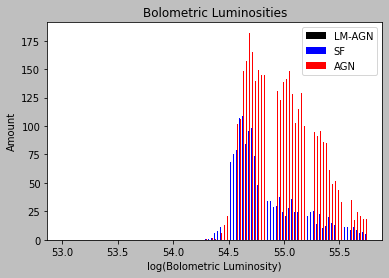

In [30]:
plt.style.use('grayscale')
bins = np.linspace(53, 55.75, 100)
colors = ['k', 'b', 'r']
plt.hist([log_bolometric_lowmetagn, log_bolometric_sf, log_bolometric_agn], bins, label=['LM-AGN', 'SF', 'AGN'], color=colors)

plt.legend(loc='upper right')
plt.title('Bolometric Luminosities')
plt.xlabel('log(Bolometric Luminosity)')
plt.ylabel('Amount')
plt.show()

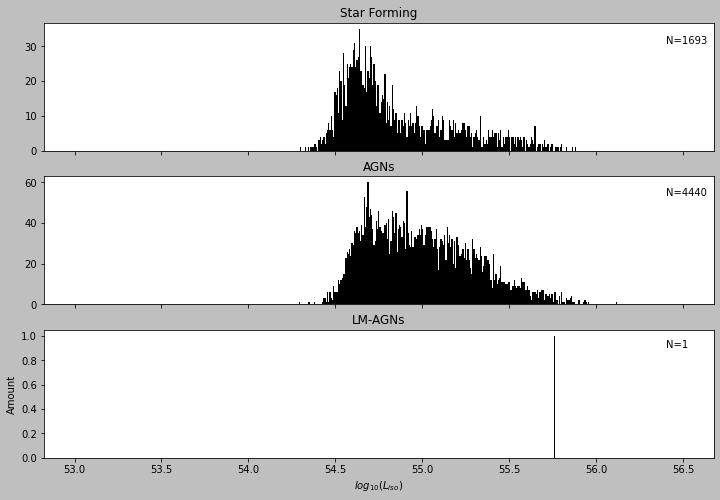

In [34]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(12, 8))
bins = np.linspace(53, 56.5, 500)

sf_hist = axs[0].hist(log_bolometric_sf, bins=bins)
axs[0].set_title('Star Forming')
agn_hist = axs[1].hist(log_bolometric_agn, bins=bins)
axs[1].set_title('AGNs')
lm_agn_hist = axs[2].hist(log_bolometric_lowmetagn, bins=bins)
axs[2].set_title('LM-AGNs')

plt.text(56.4, 3.4, 'N=1693')
plt.text(56.4, 2.15, 'N=4440')
plt.text(56.4, 0.9, 'N=1')

plt.xlabel(r'$log_{10}(L_{iso})$')
plt.ylabel('Amount')
plt.show()

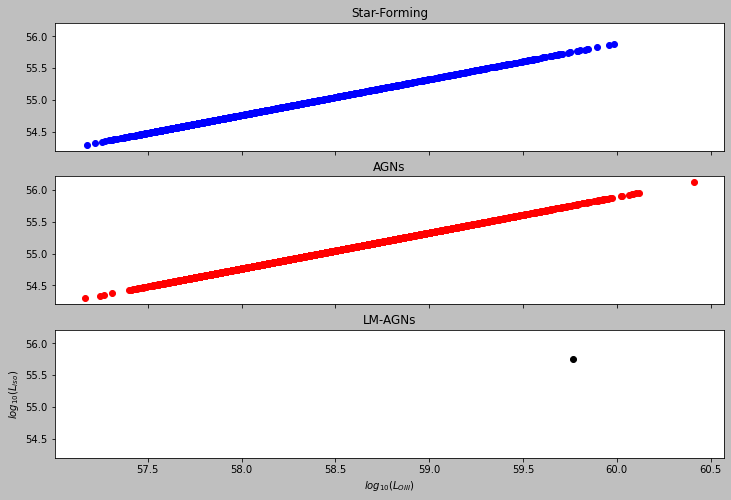

In [27]:
plt.style.use('grayscale')
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(12, 8))

sf_scatter = axs[0].scatter(dfsf['log(o3_lumin)'], dfsf['log(bolo_lumin)'], c='b')
axs[0].set_title('Star-Forming')
agn_scatter = axs[1].scatter(dfagn['log(o3_lumin)'], dfagn['log(bolo_lumin)'], c='r')
axs[1].set_title('AGNs')
lm_agn_scatter = axs[2].scatter(dflowmetagn['log(o3_lumin)'], dflowmetagn['log(bolo_lumin)'], c='k')
axs[2].set_title('LM-AGNs')

plt.ylabel(r'$log_{10}(L_{iso})$')
plt.xlabel(r'$log_{10}(L_{OIII})$')
plt.show()